In [94]:
# imports
import numpy as np
import random
import pprint as pp
import prior
import matplotlib.pyplot as plt
import math
import cv2

from PIL import Image
from typing import List, Tuple, Dict, Any
from ai2thor.controller import Controller

In [107]:
dataset = prior.load_dataset("procthor-10k")
house = dataset["train"][11]
controller = Controller(scene=house, visibilityDistance=3, width=750, height=750)

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5834.44it/s]


In [108]:
class AgentNavigator:
    """
    A class that encapsulates navigation logic for an AI agent within the AI2Thor environment. 
    It provides methods for the agent to explore rooms, move to objects of interest, perform 360-degree scans, and switch rooms.
    The class maintains internal state about the environment facilitating efficient and informed navigation.
    """    
    def __init__(self, controller: object):
        self.controller = controller
        self.agent_position = controller.last_event.metadata["agent"]["position"]
        self.room_data = self.initialize_room_data()

    
    def initialize_room_data(self) -> Dict[str, Any]:
        """
        Initializes an empty dictionary to store room data.
        """
        event = self.controller.last_event
        return {
            'rooms': {
                'room_1': {
                    'doors': {},
                    'visited_doors': set(),
                    'visible_objects': {},
                    'previous_room': None,
                    'visited_positions': {(self.agent_position['x'], self.agent_position['y'], self.agent_position['z'])},
                    'visited_objects': set(),
                }
            },
            'current_room': 'room_1'
        }


    def rotate_right(self):
        event = self.controller.step(action='RotateRight', degrees=90)

    
    def rotate_left(self):
        event = self.controller.step(action='RotateLeft', degrees=90)

    
    def get_reachable_positions(self) -> List[Dict[str, float]]:
        """
        Get all reachable positions in the environment.
        """
        event = self.controller.step(action='GetReachablePositions')
        return event.metadata['actionReturn']

    
    def calculate_distance(self, position_1: Dict[str, float], position_2: Dict[str, float]) -> float:
        """
        Calculate Euclidean distance between two positions.
        """
        pos1 = np.array([position_1['x'], position_1['y'], position_1['z']])
        pos2 = np.array([position_2['x'], position_2['y'], position_2['z']])
        return np.linalg.norm(pos1 - pos2)

    
    def find_best_position_near_door(self, agent_pos, door_coords):
        reachable_positions = self.get_reachable_positions()
        # Sort by distance to door
        reachable_positions.sort(key=lambda pos: self.calculate_distance(pos, door_coords))
        
        # Take the four closest
        closest_four = reachable_positions[:4] if len(reachable_positions) >= 4 else reachable_positions
    
        # From these four, pick the one furthest from agent
        best_position = max(closest_four, key=lambda pos: self.calculate_distance(pos, agent_pos))
        return best_position

    
    def perform_360_view(self):
        """
        Perform a 360° view from the current position and update room data.
        """
        current_room_key = self.room_data['current_room']
        current_room = self.room_data['rooms'][current_room_key]
        images = []
        def process_view(event):
            images.append(event.frame)
            for obj in event.metadata['objects']:
                if obj['visible']:
                    obj_id = obj['objectId']
                    pos = obj['position']
                    current_room['visible_objects'][obj_id] = {
                        'name': obj['name'],
                        'object_type': obj['objectType'],
                        'position': pos
                    }
                    # Store doors
                    if obj['objectType'] == 'Doorway' and obj_id not in current_room['doors']:
                        current_room['doors'][obj_id] = {
                            'coordinates': pos,
                            'explored': False
                        }

        for i in range(4):
            event = self.controller.last_event
            process_view(event)
            if i < 3:
                # Rotate the agent and get the new event
                event = self.controller.step(action='RotateRight', degrees=90)

        # # Stitch images into a panorama
        # panorama = self.stitch_images(images)

        # # Save panorama image
        # panorama_path = "room_panorama.jpg"
        # cv2.imwrite(panorama_path, panorama)
        # return panorama_path


    # def stitch_images(self, images):
    #     """
    #     Stitch a list of images into a 360° panorama using OpenCV.
    #     """
    #     # Convert images to OpenCV format
    #     cv_images = [cv2.cvtColor(np.array(Image.fromarray(img)), cv2.COLOR_RGB2BGR) for img in images]

    #     # Use OpenCV's stitcher
    #     stitcher = cv2.Stitcher_create()
    #     status, stitched_image = stitcher.stitch(cv_images)

    #     if status == cv2.Stitcher_OK:
    #         return stitched_image
    #     else:
    #         raise Exception(f"Image stitching failed with status code {status}")

    
    def explore_room(self):
        """
        Explore the current room by moving to a new position.
        """
        current_room_key = self.room_data['current_room']
        current_room = self.room_data['rooms'][current_room_key]
        agent_pos = self.agent_position
        reachable_positions = self.get_reachable_positions()
    
        # Convert visited positions into a list of dicts for distance calculations
        visited_positions_list = [
            {'x': x, 'y': y, 'z': z} 
            for (x, y, z) in current_room['visited_positions']
        ]
    
        # Filter positions within a distance of 3 from ANY visited position
        positions_within_range = [
            pos for pos in reachable_positions
            if any(self.calculate_distance(vp, pos) <= 3.0 for vp in visited_positions_list)
        ]
    
        # Exclude positions already visited
        unvisited_positions = [
            pos for pos in positions_within_range
            if (pos['x'], pos['y'], pos['z']) not in current_room['visited_positions']
        ]
    
        if not unvisited_positions:
            print("No new positions to explore within range.")
            return
    
        # Find the position furthest from the agent's current position
        target_position = max(
            unvisited_positions,
            key=lambda pos: self.calculate_distance(agent_pos, pos)
        )
    
        # Move the agent to the target position
        try:
            event = self.controller.step(action='Teleport', position=target_position)
            if not event.metadata['lastActionSuccess']:
                print(f"Teleport failed to position: {target_position}")
                return
            # Add the position to visited_positions
            current_room['visited_positions'].add((target_position['x'], target_position['y'], target_position['z']))
            self.agent_position = event.metadata['agent']['position']
            print(f"Agent moved to new position: {target_position}")
        except Exception as e:
            print(f"Error while moving to new position: {e}")

    
    def teleport_to_door(self, door_id: str):
        """
        Teleport the agent to a door and update its status.
        """
        current_room_key = self.room_data['current_room']
        current_room = self.room_data['rooms'][current_room_key]
        agent_pos = self.controller.last_event.metadata['agent']['position']

        door_info = current_room['doors'][door_id]
        door_coords = door_info['coordinates']

        target_position = self.find_best_position_near_door(agent_pos, door_coords)
        if not target_position:
            print("No valid position found near the door.")
            return False
        try:
            event = self.controller.step(action='Teleport', position=target_position)
            if not event.metadata['lastActionSuccess']:
                print(f"Failed to teleport to position {target_position}.")
                return False
            self.agent_position = event.metadata['agent']['position']
        except Exception as e:
            print(f"Exception occurred during teleport: {e}")
            return False

            
        # Update the door as explored
        current_room['doors'][door_id]['explored'] = True

        # Add a new room if it's unexplored
        room_number = len(self.room_data['rooms']) + 1
        new_room_key = f"room_{room_number}"
        if new_room_key not in self.room_data['rooms']:
            self.room_data['rooms'][new_room_key] = {
                'doors': {},
                'visited_doors': set(),
                'visible_objects': {},
                'previous_room': current_room_key,
                'visited_positions': {(self.agent_position['x'], self.agent_position['y'], self.agent_position['z'])},
                'visited_objects': set()
            }
            # Add this door to the new room's dictionary as well, marking it as explored
            self.room_data['rooms'][new_room_key]['doors'][door_id] = {
            'coordinates': door_coords,
            'explored': True
            }
            self.room_data['current_room'] = new_room_key
        print(f"Entered new room: {new_room_key}")
        # Close the door after teleportation
        self.close_door()
        print("Closed the door.")


    def close_door(self):
        event = self.controller.last_event
        objects = event.metadata['objects']
    
        # Find open, openable doors
        open_doors = [
            obj for obj in objects
            if obj['objectType'] == 'Doorway' and obj.get('openable', False) and obj.get('isOpen', False)
        ]
    
        if not open_doors:
            print("No open doors found.")
            return
    
        # Pick the closest open door
        closest_door = min(
            open_doors,
            key=lambda d: self.calculate_distance(self.agent_position, d['position'])
        )
    
        # Close the door
        door_id = closest_door['objectId']
        close_event = self.controller.step(action='CloseObject', objectId=door_id)
        if not close_event.metadata['lastActionSuccess']:
            print("Failed to close the door.")
            return    
            
    
    def switch_new_room(self):
        """
        Move the agent to a new room through a door. If room_type is provided, move to a room of that type.
        """
        current_room_key = self.room_data['current_room']
        current_room = self.room_data['rooms'][current_room_key]

        # Move to unexplored door
        unexplored_doors = [
            (door_id, door_info) for door_id, door_info in current_room['doors'].items()
            if not door_info['explored']
        ]
        if not unexplored_doors:
            print("No unexplored doors available in the current room.")
            return False

        # Select the first unexplored door
        door_id, _ = unexplored_doors[0]
        return self.teleport_to_door(door_id)


    def return_previous_room(self):
        current_room_key = self.room_data['current_room']
        current_room = self.room_data['rooms'][current_room_key]
        prev_room_key = current_room.get('previous_room', None)
    
        if not prev_room_key:
            print("No previous room recorded. Cannot return.")
            return False
    
        previous_room = self.room_data['rooms'][prev_room_key]
        visited_positions = previous_room.get('visited_positions', None)
    
        if not visited_positions:
            print(f"No visited positions recorded for previous room: {prev_room_key}")
            return False
    
        # Convert the set of visited positions into a list so we can pick one
        visited_positions_list = list(visited_positions)
    
        # Choose a random visited position from the previous room
        chosen_pos_tuple = random.choice(visited_positions_list)
        chosen_pos = {'x': chosen_pos_tuple[0], 'y': chosen_pos_tuple[1], 'z': chosen_pos_tuple[2]}
    
        # Attempt to teleport the agent back to this visited position
        event = self.controller.step(action='Teleport', position=chosen_pos)
        if event.metadata['lastActionSuccess']:
            self.agent_position = event.metadata['agent']['position']
            self.room_data['current_room'] = prev_room_key
            print(f"Returned to previous room: {prev_room_key} at {chosen_pos}")
            return True
        else:
            print(f"Failed to teleport to position {chosen_pos} in previous room {prev_room_key}.")
            return False

In [109]:
# Testing
navigator = AgentNavigator(controller)

In [117]:
# Perform initial 360° view
# navigator.perform_360_view()
# pp.pprint(navigator.room_data)

# Explore the room
# navigator.explore_room()

# Switch to a different room
# navigator.switch_new_room()

# Switch to previous room
# navigator.return_previous_room()

# Perform 360° view in the new room
# navigator.perform_360_view()

Returned to previous room: room_1 at {'x': 1.5, 'y': 0.9009993672370911, 'z': 7.5}


True

### Image of current view agent

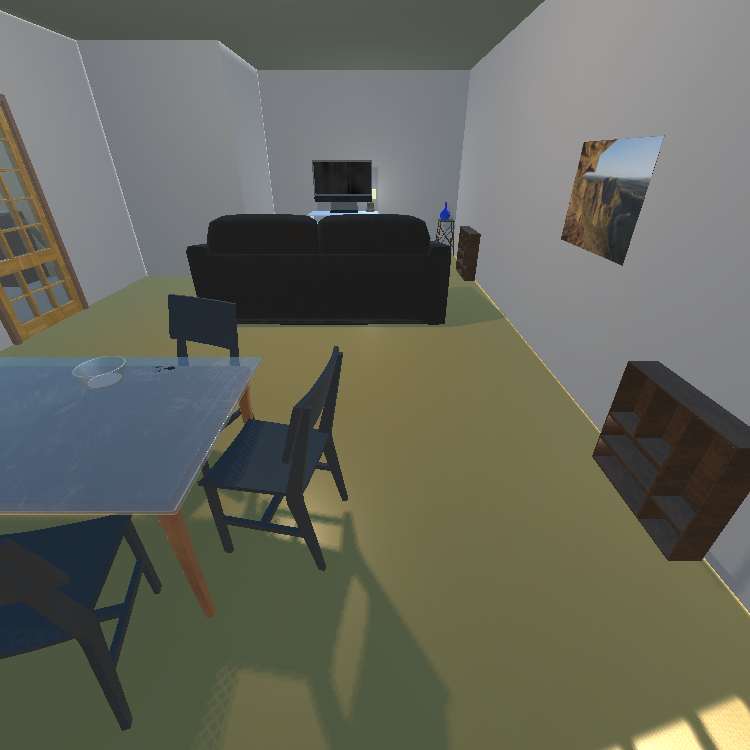

In [118]:
Image.fromarray(controller.last_event.frame)

In [38]:
event = controller.step(action="GetReachablePositions")
reachable_positions = event.metadata["actionReturn"]

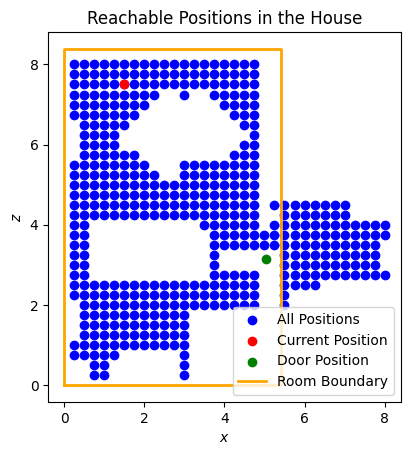

In [68]:
# Plot reachable positions within all positions
xs = [ap["x"] for ap in reachable_positions]
zs = [ap["z"] for ap in reachable_positions]

# Current position
current_position = controller.last_event.metadata["agent"]["position"]
door = {'x': 5.033295631408691, 'y': -0.0022848844528198242, 'z': 3.1393861770629883}

# Generate the plot
fig, ax = plt.subplots(1, 1)
ax.scatter(xs, zs, label="All Positions", color="blue")
ax.scatter(current_position["x"], current_position["z"], label="Current Position", color="red")
ax.scatter(door["x"], door["z"], label="Door Position", color="green")

# Extract the floor object from metadata
floor_object = next(
    obj for obj in controller.last_event.metadata['objects'] if obj['objectType'] == 'Floor'
)

# Get the floor's bounding box corner points
floor_bounds = floor_object['axisAlignedBoundingBox']
corner_points = floor_bounds['cornerPoints']

# Extract unique (x, z) pairs from corner points
corner_tuples = set()
for point in corner_points:
    x, z = point[0], point[2]
    corner_tuples.add((x, z))

# Convert the set to a list and sort it to maintain order
corner_list = list(corner_tuples)

# Since it's a rectangle, define the boundary in order to plot correctly
# Extract x and z coordinates
x_coords = [x for x, z in corner_list]
z_coords = [z for x, z in corner_list]

# Find the min and max values to arrange the corners
x_min, x_max = min(x_coords), max(x_coords)
z_min, z_max = min(z_coords), max(z_coords)

# Define the rectangle boundary coordinates
boundary_xs = [x_min, x_max, x_max, x_min, x_min]  # Closing the rectangle by repeating the first point
boundary_zs = [z_min, z_min, z_max, z_max, z_min]  # Same here

# Plot the room boundary
ax.plot(boundary_xs, boundary_zs, color='orange', label='Room Boundary', linewidth=2)

# Add labels and title
ax.set_xlabel("$x$")
ax.set_ylabel("$z$")
ax.set_title("Reachable Positions in the House")
ax.set_aspect("equal")
ax.legend()

# Show the plot
plt.show()

In [92]:
for object in controller.last_event.metadata["objects"]:
  if object["visible"]:
    print(object["name"])

CounterTop|2|0
door|2|3
Fridge|2|1
HousePlant|2|3|0
Shelf (5)
Shelf (4)
ShelvingUnit|2|2
Spatula|surface|2|6
SprayBottle|surface|2|1
Vase|surface|2|7
wall|3|5.03|1.68|5.03|5.03
wall|2|5.03|5.03|8.39|5.03
wall|2|5.03|1.68|8.39|1.68
wall|exterior|5.03|5.03|8.39|5.03
window|2|0


In [32]:
# print(reachable_positions)

In [60]:
for object in controller.last_event.metadata["objects"]:
  if object["name"] == "door|2|3":
    print(object)

{'name': 'door|2|3', 'position': {'x': 5.033295631408691, 'y': -0.0022848844528198242, 'z': 3.1393861770629883}, 'rotation': {'x': -0.0, 'y': 90.0, 'z': -0.0}, 'visible': True, 'isInteractable': True, 'receptacle': False, 'toggleable': False, 'isToggled': False, 'breakable': False, 'isBroken': False, 'canFillWithLiquid': False, 'isFilledWithLiquid': False, 'fillLiquid': None, 'dirtyable': False, 'isDirty': False, 'canBeUsedUp': False, 'isUsedUp': False, 'cookable': False, 'isCooked': False, 'temperature': 'RoomTemp', 'isHeatSource': False, 'isColdSource': False, 'sliceable': False, 'isSliced': False, 'openable': True, 'isOpen': True, 'openness': 1.0, 'pickupable': False, 'isPickedUp': False, 'moveable': False, 'mass': 0.0, 'salientMaterials': None, 'receptacleObjectIds': None, 'distance': 3.1348981857299805, 'objectType': 'Doorway', 'objectId': 'door|2|3', 'assetId': 'Doorway_5', 'parentReceptacles': ['Floor'], 'controlledObjects': None, 'isMoving': False, 'axisAlignedBoundingBox': {'c

In [93]:
for object in controller.last_event.metadata["objects"]:
  if object["objectType"] == "Floor":
    print(object)

{'name': 'room|3', 'position': {'x': 0.0, 'y': 0.0, 'z': 0.0}, 'rotation': {'x': -0.0, 'y': 0.0, 'z': 0.0}, 'visible': False, 'isInteractable': False, 'receptacle': False, 'toggleable': False, 'isToggled': False, 'breakable': False, 'isBroken': False, 'canFillWithLiquid': False, 'isFilledWithLiquid': False, 'fillLiquid': None, 'dirtyable': False, 'isDirty': False, 'canBeUsedUp': False, 'isUsedUp': False, 'cookable': False, 'isCooked': False, 'temperature': 'RoomTemp', 'isHeatSource': False, 'isColdSource': False, 'sliceable': False, 'isSliced': False, 'openable': False, 'isOpen': False, 'openness': 0.0, 'pickupable': False, 'isPickedUp': False, 'moveable': False, 'mass': 0.0, 'salientMaterials': None, 'receptacleObjectIds': None, 'distance': 6.118561744689941, 'objectType': 'Floor', 'objectId': 'room|3', 'assetId': '', 'parentReceptacles': ['Floor'], 'controlledObjects': None, 'isMoving': False, 'axisAlignedBoundingBox': {'cornerPoints': [[5.419638633728027, 0.0, 8.387999534606934], [5

In [75]:
current_position = controller.last_event.metadata["agent"]["position"]
print(current_position)

{'x': 2.5, 'y': 0.9009997844696045, 'z': 4.75}
